# Gruey Model Training and Loss Visualization

This notebook loads the engineered training data, preprocesses it, trains the GrueyModel (similar to `src/python/training/gruey.py`), and plots the training and validation loss curves.

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Add project root for potential utility imports if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Configuration --- 
DATA_PATH = os.path.join(project_root, 'data', 'processed', 'train_engineered.csv')
TARGET_VARIABLE = 'Duration_In_Min' 
DROPPED_COLUMNS = ['Course_Code_by_Thousands', 'Semester', 'Occupancy', 'Expected_Graduation', 
                   'Class_Standing', 'Check_Out_Time', 'Course_Name', 'Major', 'Check_In_Date', 
                   'Expected_Graduation_Date', 'Session_Length_Category', 'Semester_Date', 
                   'Course_Number', 'Student_IDs', 'Course_Type']
TIME_COLUMN = 'Check_In_Time' # Column to convert to minutes
CATEGORICAL_COLS = ['Degree_Type', 'Gender', 'Check_In_Day', 'Check_In_Month', 'Time_Category', 
                    'Course_Level', 'Course_Name_Category', 'Course_Type_Category', 'Major_Category', 
                    'GPA_Category', 'Credit_Load_Category', 'Class_Standing_Self_Reported', 
                    'Class_Standing_BGSU', 'Week_Volume', 'Group_Size_Category']

BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30 # <<< You can change the number of epochs here
HIDDEN_SIZE = 64  # Example hidden size for GRU/Linear layers
TEST_SIZE = 0.2
RANDOM_STATE = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Preprocessing Utilities

In [25]:
class TabularDataset(Dataset):
    """Custom Dataset for tabular data."""
    def __init__(self, features, targets):
        # Convert pandas DataFrames/Series to numpy arrays first, then to tensors
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32).unsqueeze(1) # Ensure target is [n_samples, 1]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

def preprocess_data(df, target_variable, dropped_columns, time_column, categorical_cols, fit_columns=None):
    """Preprocesses the dataframe: handles time, drops columns, creates dummies, aligns columns."""
    print("Starting preprocessing...")
    df_processed = df.copy()

    # 1. Separate Target Variable
    if target_variable in df_processed.columns:
        y = df_processed[target_variable]
        X = df_processed.drop(columns=[target_variable])
        print(f"Separated target variable: {target_variable}")
    else:
        y = None # No target in test data usually
        X = df_processed
        print("No target variable found, assuming test data.")

    # 2. Drop Specified Columns
    cols_to_drop_existing = [col for col in dropped_columns if col in X.columns]
    X = X.drop(columns=cols_to_drop_existing)
    print(f"Dropped columns: {cols_to_drop_existing}")

    # 3. Convert Time Column to Minutes
    if time_column in X.columns:
        print(f"Converting {time_column} to minutes...")
        try:
            time_obj = pd.to_datetime(X[time_column], format='%H:%M:%S').dt
            X[time_column + '_Minutes'] = time_obj.hour * 60 + time_obj.minute + time_obj.second / 60
            X = X.drop(columns=[time_column])
            print(f"Created '{time_column}_Minutes' and dropped original.")
        except Exception as e:
            print(f"Could not convert {time_column} to minutes: {e}")

    # 4. Create Dummy Variables for Categorical Columns
    categorical_cols_existing = [col for col in categorical_cols if col in X.columns]
    if categorical_cols_existing:
        print(f"Creating dummy variables for: {categorical_cols_existing}")
        X = pd.get_dummies(X, columns=categorical_cols_existing, dummy_na=False)
        print(f"DataFrame shape after dummies: {X.shape}")

    # 5. Ensure all columns are numeric (handle booleans specifically)
    print("Converting boolean columns to int...")
    for col in X.columns:
        if X[col].dtype == 'bool':
            X[col] = X[col].astype(int)
        # Ensure remaining columns are numeric, coerce errors to NaN, then fill NaN
        elif not pd.api.types.is_numeric_dtype(X[col]):
             print(f"Warning: Column '{col}' is not numeric ({X[col].dtype}). Attempting conversion.")
             X[col] = pd.to_numeric(X[col], errors='coerce')
             # Optionally fill NaNs created during coercion, e.g., with median or 0
             # X[col] = X[col].fillna(X[col].median()) # Or X[col].fillna(0)
    
    # Fill any remaining NaNs (e.g., from original data or failed coercions)
    if X.isnull().sum().sum() > 0:
        print("Filling remaining NaNs with 0...") # Consider a more robust strategy if needed
        X = X.fillna(0)

    # 6. Align Columns based on 'fit_columns' (training columns)
    if fit_columns is not None:
        print("Aligning columns with training set...")
        missing_cols = set(fit_columns) - set(X.columns)
        for c in missing_cols:
            X[c] = 0
        print(f"Added missing columns to test: {list(missing_cols)}")
        
        extra_cols = set(X.columns) - set(fit_columns)
        X = X.drop(columns=list(extra_cols))
        print(f"Removed extra columns from test: {list(extra_cols)}")
        
        X = X[fit_columns] # Ensure order matches training data
        print("Aligned test columns with training columns.")

    # 7. Placeholder for Scaling/Feature Selection (apply AFTER column alignment)
    # scaler = StandardScaler() # Example
    # if fit_columns is not None: # Apply fitted scaler
    #    X[X.columns] = scaler.transform(X[X.columns])
    # else: # Fit scaler on training data
    #    X[X.columns] = scaler.fit_transform(X[X.columns])
    print("Placeholder: Scaling would be applied here.")
    print("Placeholder: Feature selection would be applied here.")

    # Convert all feature columns to float32 for PyTorch
    X = X.astype(np.float32)

    print(f"Preprocessing finished. Final X shape: {X.shape}, y length: {len(y) if y is not None else 'N/A'}")
    return X, y, X.columns # Return X.columns for test set alignment

## Model Definition (Gruey)

In [26]:
# Replicating the GrueyModel structure from src/python/models/gruey_model.py
# (Assuming it uses minGRU or a similar structure)

class Identity(nn.Module):
    def forward(self, x):
        return x

# --- Simplified minGRU Layer --- (Replace with actual if available)
class minGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # Combined linear layer for update gate (z) and reset gate (r)
        self.to_hidden_and_gate = nn.Linear(input_size + hidden_size, 2 * hidden_size, bias=False)
        # Linear layer for candidate hidden state (n)
        self.to_candidate = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # Output layer (often identity if followed by another layer)
        self.to_out = Identity()

    def forward(self, x, h = None):
        # x shape: [batch_size, input_size]
        batch_size, _ = x.shape
        
        # Initialize hidden state if not provided
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Combine input and previous hidden state
        combined_input = torch.cat((x, h), dim=1)

        # Calculate gates (reset r, update z)
        gates = self.to_hidden_and_gate(combined_input)
        r, z = gates.chunk(2, dim=1)
        r = torch.sigmoid(r) # Reset gate
        z = torch.sigmoid(z) # Update gate

        # Calculate candidate hidden state
        combined_candidate_input = torch.cat((x, r * h), dim=1)
        n = self.to_candidate(combined_candidate_input)
        n = torch.tanh(n) # Candidate hidden state

        # Calculate new hidden state
        h_new = (1 - z) * n + z * h

        # Output
        output = self.to_out(h_new)
        return output, h_new
    
# --- Gruey Model --- (Adapted for Tabular Data)
# This version applies a GRU-like update once per sample, 
# treating the whole feature vector as the input at a single 'time step'.
class GrueyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Optional: Initial linear layer to project input features to hidden size
        self.input_fc = nn.Linear(input_size, hidden_size)
        # Using our simplified minGRU layer
        self.gru = minGRU(hidden_size, hidden_size) # Input to GRU is now hidden_size
        # Final output layer
        self.output_fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h=None):
        # x shape: [batch_size, input_size]
        
        # 1. Initial projection
        projected_x = torch.relu(self.input_fc(x)) # Use relu or other activation

        # 2. Apply GRU update (single step)
        # The 'output' from minGRU here is the same as the new hidden state 'h_new'
        gru_output, h_new = self.gru(projected_x, h)

        # 3. Final prediction
        output = self.output_fc(gru_output)
        
        return output # Return final prediction

## Training and Evaluation Utilities

In [27]:
# --- Training Step Function ---
def train_step(model: torch.nn.Module, 
               features: torch.Tensor, 
               targets: torch.Tensor, 
               loss_fn: torch.nn.modules.loss._Loss, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    """Performs a single training step."""
    model.train()
    features, targets = features.to(device), targets.to(device)
    
    predictions = model(features)
    loss = loss_fn(predictions, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

# --- Evaluation Function ---
def evaluate_model(model: torch.nn.Module,
                   data_loader: DataLoader,
                   loss_fn: torch.nn.modules.loss._Loss,
                   device: torch.device) -> float:
    """Evaluates the model on the provided data loader."""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            predictions = model(features)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

## Main Training Process

In [28]:
# 1. Load Data
try:
    print(f"Attempting to load data from: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
    print("\nData loaded successfully:")
    # print(df.head())
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PATH}")
    df = None
except Exception as e:
    print(f"Error loading data: {e}")
    df = None

if df is not None:
    # 2. Train/Test Split
    print(f"\nSplitting data (Test size: {TEST_SIZE}, Random state: {RANDOM_STATE})...")
    df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    print(f"Data split: Train={df_train.shape[0]} rows, Test={df_test.shape[0]} rows")

    # 3. Preprocess Data
    print("\nPreprocessing training data...")
    X_train, y_train, train_cols = preprocess_data(df_train, TARGET_VARIABLE, DROPPED_COLUMNS, TIME_COLUMN, CATEGORICAL_COLS)
    
    print("\nPreprocessing test data...")
    X_test, y_test, _ = preprocess_data(df_test, TARGET_VARIABLE, DROPPED_COLUMNS, TIME_COLUMN, CATEGORICAL_COLS, fit_columns=train_cols)

    # 4. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = TabularDataset(X_train, y_train)
    test_dataset = TabularDataset(X_test, y_test)
    print(f"Created TabularDataset: {len(train_dataset)} samples, {X_train.shape[1]} features.")
    print(f"Created TabularDataset: {len(test_dataset)} samples, {X_test.shape[1]} features.")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 5. Initialize Model, Loss, Optimizer
    input_dim = X_train.shape[1]
    output_dim = 1 # Predicting a single value (Duration_In_Min)
    print(f"\nInput dimension for model: {input_dim}")
    
    model = GrueyModel(input_dim, HIDDEN_SIZE, output_dim).to(device)
    loss_fn = nn.MSELoss() # Mean Squared Error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("Model, Loss Function, Optimizer initialized.")
    print(model)

    # 6. Training Loop
    print(f"\nStarting training for {NUM_EPOCHS} epochs...")
    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in range(NUM_EPOCHS):
        epoch_train_loss = 0.0
        for batch_idx, (features, targets) in enumerate(train_loader):
            loss = train_step(model, features, targets, loss_fn, optimizer, device)
            epoch_train_loss += loss

        avg_epoch_train_loss = epoch_train_loss / len(train_loader)
        avg_epoch_val_loss = evaluate_model(model, test_loader, loss_fn, device)

        train_losses_epoch.append(avg_epoch_train_loss)
        val_losses_epoch.append(avg_epoch_val_loss)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg Train Loss: {avg_epoch_train_loss:.4f}, Avg Val Loss: {avg_epoch_val_loss:.4f}")

    print("\nTraining finished.")

Attempting to load data from: /workspaces/sp25-m7560-final-project/data/processed/train_engineered.csv
Successfully loaded 11734 rows and 87 columns.

Data loaded successfully:

Splitting data (Test size: 0.2, Random state: 3)...
Data split: Train=9387 rows, Test=2347 rows

Preprocessing training data...
Starting preprocessing...
Separated target variable: Duration_In_Min
Dropped columns: ['Course_Code_by_Thousands', 'Semester', 'Occupancy', 'Expected_Graduation', 'Class_Standing', 'Check_Out_Time', 'Course_Name', 'Major', 'Check_In_Date', 'Expected_Graduation_Date', 'Session_Length_Category', 'Semester_Date', 'Course_Number', 'Student_IDs', 'Course_Type']
Converting Check_In_Time to minutes...
Created 'Check_In_Time_Minutes' and dropped original.
Creating dummy variables for: ['Degree_Type', 'Gender', 'Check_In_Day', 'Check_In_Month', 'Time_Category', 'Course_Level', 'Course_Name_Category', 'Course_Type_Category', 'Major_Category', 'GPA_Category', 'Credit_Load_Category', 'Class_Standi


Plotting losses...


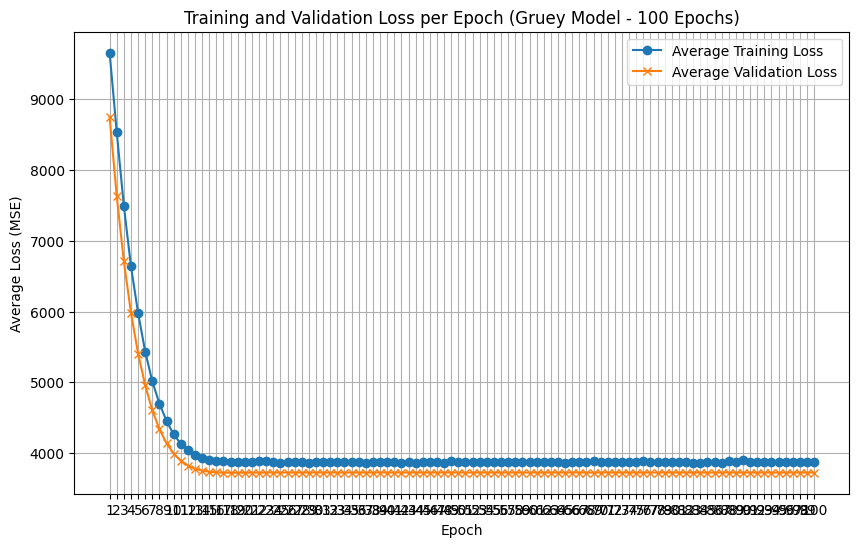

In [29]:
# 7. Plotting the results
print("\nPlotting losses...")
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses_epoch, label='Average Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses_epoch, label='Average Validation Loss', marker='x')
plt.title(f'Training and Validation Loss per Epoch (Gruey Model - {NUM_EPOCHS} Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss (MSE)')
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.grid(True)
plt.show()
